In [1]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re

In [2]:
# 법령 XML 상세조회 (시행기준. target=eflaw)

#기본 url
url_base = " http://www.law.go.kr/DRF/lawService.do"

#조회 url 세부 설정
user_id = 'bmsong' #open API ID (bmsong@kau.ac.kr의 아이디 부분)
target = "eflaw" #법령 조회시
MST = "218289" #ID 또는 MST #산업안전보건법 MST 218289
#ID = "001766" 
            #ID 산업안전보건법 법령ID 001766 (설명에는 ID로 조회하면 현행법령이 조회된다는데, 
            #target을 eflaw로 하면 ID로 요청해도, MST로 요청해도 같은 것 같다.
Type = "XML" #출력 형태 : HTML 또는 XML

url_sub = "?" +\
        "OC=" + user_id +\
        "&target=" + target +\
        "&MST=" + MST +\
        "&type=" + Type

#최종 url
url = url_base + url_sub

print(url)

response = requests.get(url)

#(1) response.text 사용하는 방법
#soup = BeautifulSoup(response.text.encode('utf-8'), 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)

#(2) response.content 사용하는 방법
soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)


# soup

 http://www.law.go.kr/DRF/lawService.do?OC=bmsong&target=eflaw&MST=218289&type=XML


In [3]:
lc_basic_df = pd.DataFrame() #DataFrame for Law Content 

data = soup.find('법령ID') #MST 정보
lc_basic_df['법령ID'] = [data.get_text()]

data = soup.find('법종구분') 
lc_basic_df['법종구분']= [data.get_text()]

data = soup.find('법령명_한글') 
lc_basic_df['법령명']= [data.get_text()]

data = soup.find('시행일자')
lc_basic_df['시행일자'] = [data.get_text()]

data = soup.find('공포일자') 
lc_basic_df['공포일자']= [data.get_text()]

data = soup.find('소관부처') 
lc_basic_df['소관부처']= [data.get_text()]

lc_basic_df

,법령ID,법종구분,법령명,시행일자,공포일자,소관부처
0,001766,법률,산업안전보건법,20210116,20200526,고용노동부


In [4]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)

#         if i.find("항내용"):
#             for j in i.find_all("항내용"):
#                 detail["항문내용"] = j.get_text().strip()
#                 df_info = df_info.append(detail,ignore_index = True)
#                 if i.find("호내용"):
#                     for k in i.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info.head(30)

In [5]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)
        
#         if i.find("항"):
#             for j in i.find_all("항"):
#                 if j.find("항내용"):
#                     detail["항문내용"] = j.항내용.get_text().strip()
#                     df_info = df_info.append(detail,ignore_index = True)
#                 if j.find("호내용"):
#                     for k in j.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info

In [6]:
data = soup.find_all('조문단위')
df_info = pd.DataFrame()
info = []
for i in data:
    info_str = ""
    if i.find("조문여부").get_text() == "조문":
        info_str += i.조문내용.get_text().strip()
        if i.항:
            hang_nums = i.find_all("항번호")
            ho_nums = i.find_all("호번호")
            for idx, p in enumerate(i.find_all("호내용")):
                info_str += p.get_text().split(ho_nums[idx].get_text())[1].strip()
            for hang_idx, k in enumerate(i.find_all("항내용")):
                info_str += k.get_text().strip().split(hang_nums[hang_idx].get_text())[1].strip()
                for ho_idx ,j in enumerate(i.find_all("호내용")):
                    info_str += j.get_text().strip().split(ho_nums[ho_idx].get_text())[1].strip()
        info.append(info_str)
df_info["조내용"] = info
df_info

,조내용
0,제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2,"제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업..."
3,제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...
4,제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...
...,...
172,제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173,제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174,"제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ..."
175,제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...


In [7]:
df_info.to_excel('산업안전보건법.xlsx',index = False)

# NLP(자연어 처리)



https://konlpy-ko.readthedocs.io/ko/v0.4.4/install/#id1

(konlpy를 사용하기위한 패키지를 다운받는 매뉴얼 입니다)


In [8]:
posts = df_info.get("조내용")
posts

0      제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1      제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2      제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업...
3      제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...
4      제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...
                             ...                        
172    제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173    제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174    제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ...
175    제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...
176    제175조(과태료)제119조제2항에 따라 기관석면조사를 하지 아니하고 건축물 또는 ...
Name: 조내용, Length: 177, dtype: object

In [9]:
from konlpy.tag import Mecab
tagger = Mecab()

In [10]:
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
670,일곱
671,여덟
672,아홉
673,령


In [12]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in stop_words_df:
            nouns.append(noun)
nouns[0:10]

['조', '목적', '법', '산업', '안전', '보건', '기준', '확립', '책임', '소재']

In [13]:
words = []
for post in posts:
    words.extend(tagger.pos(post))
words[0:10]

[('제', 'XPN'),
 ('1', 'SN'),
 ('조', 'NNG'),
 ('(', 'SSO'),
 ('목적', 'NNG'),
 (')', 'SSC'),
 ('이', 'JKS'),
 ('법', 'NNG'),
 ('은', 'JX'),
 ('산업', 'NNG')]

In [14]:
# 동사 추출
verbs=[]
for word in words:
    if word[1]=='VV':
        verbs.append(word[0]+'다')
verbs[0:10]

['하다', '의하다', '인하다', '걸리다', '정하다', '하다', '맡기다', '받다', '받다', '받다']

In [15]:
# 형용사 추출
adjective=[]
for word in words:
    if word[1]=='VA':
        adjective.append(word[0]+'다')
adjective[0:10]

['같다', '심하다', '있다', '없다', '같다', '같다', '같다', '같다', '같다', '없다']

In [17]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 20
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns
# print(len(counted_nouns))

{'항': 2290,
 '조제': 1533,
 '안전': 1016,
 '경우': 907,
 '조': 740,
 '보건': 671,
 '고용': 571,
 '자제': 446,
 '등': 424,
 '물질': 420,
 '호': 398,
 '위반': 382,
 '근로자': 353,
 '해당': 353,
 '사항': 347,
 '작업': 342,
 '기관': 320,
 '노동': 302,
 '부령': 301,
 '장관': 262}

In [18]:
!pip install wordcloud

In [19]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_nouns)

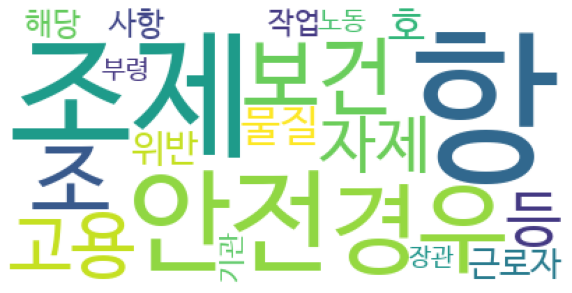

In [62]:
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

# TfidfVectorizer

 TF(Term Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수

DF(Document Frequency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

IDF(Inverse Document Frequency) : DF에 역수를 취해(inverse) 구함

TF-IDF : TF와 IDF를 곱한 값. 즉 TF가 높고, DF가 낮을수록 값이 커지는 것을 이용하는 것입니다.

해당 단위(문장) 안에서는 많이 등장하지만, 다른 문서들까지 전체에서는 적게 사용될수록, 분별력 있는 특징이란 것입니다.

In [21]:
# 자주 등장한 명사 20 개 기준
from sklearn.feature_extraction.text import TfidfVectorizer
tfidv = TfidfVectorizer(sublinear_tf = True).fit(top_nouns)
tfidv.transform(posts).toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.76749457, ..., 0.        , 0.        ,
        0.45329466],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.62791376, 0.        , 0.        , ..., 0.        , 0.        ,
        0.77828292],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.51025791, ..., 0.        , 0.        ,
        0.69229598]])

In [22]:
# 아예 등장하지 않는다면 0,
# 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것
# 작다면 그다지 가치가 없다고 판단이 가능
pd.DataFrame(tfidv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.767495,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.453295,0.0,0.0,0.453295
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.634925,0.0,0.000000,0.772574,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.386495,0.0,0.0,0.0,0.000000,0.0,0.000000,0.922291,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000
173,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
174,0.627914,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.778283
175,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.498305,0.867002,0.0,0.0,0.000000,0.0,0.0,0.000000


In [23]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(posts)
sorted(tfidf_vectorizer.vocabulary_.items())

[('100분의', 0),
 ('10시부터', 1),
 ('10억원', 2),
 ('1까지', 3),
 ('1년', 4),
 ('1년의', 5),
 ('1년이', 6),
 ('1억원', 7),
 ('1일', 8),
 ('1주', 9),
 ('1천500만원', 10),
 ('1천만원', 11),
 ('200시간의', 12),
 ('2020', 13),
 ('26', 14),
 ('2개', 15),
 ('2년', 16),
 ('2년으로', 17),
 ('2년을', 18),
 ('2년이', 19),
 ('2분의', 20),
 ('300만원', 21),
 ('30년', 22),
 ('31', 23),
 ('34시간을', 24),
 ('3년', 25),
 ('3년의', 26),
 ('3일', 27),
 ('3천만원', 28),
 ('500만원', 29),
 ('5년', 30),
 ('5년간', 31),
 ('5년마다', 32),
 ('5년으로', 33),
 ('5천만원', 34),
 ('60개월을', 35),
 ('6개월', 36),
 ('6시간', 37),
 ('6시까지', 38),
 ('6의', 39),
 ('7년', 40),
 ('fume', 41),
 ('mist', 42),
 ('ㆍ미스트', 43),
 ('ㆍ산소결핍ㆍ병원체', 44),
 ('ㆍ제2항', 45),
 ('ㆍ제2항을', 46),
 ('使用年限', 47),
 ('倂科', 48),
 ('共謀', 49),
 ('動力', 50),
 ('危害', 51),
 ('實刑', 52),
 ('敎唆', 53),
 ('疫學調査', 54),
 ('精密工作', 55),
 ('計上', 56),
 ('計測監視', 57),
 ('試料', 58),
 ('財源', 59),
 ('가공', 60),
 ('가능하지', 61),
 ('가능한', 62),
 ('가동해서는', 63),
 ('가맹본부', 64),
 ('가맹본부는', 65),
 ('가맹본부의', 66),
 ('가맹사업거래의', 67),
 ('가맹점사업자에게', 68),
 ('가맹

In [48]:
tfidfv = TfidfVectorizer().fit_transform(posts)
tfidfv.toarray()


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.11042345, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [53]:
from konlpy.tag import Okt
okt = Okt()

oo = okt.pos(posts[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )
print(oo)

[('제', 'Noun'), ('1조', 'Number'), ('(', 'Punctuation'), ('목적', 'Noun'), (')', 'Punctuation'), ('이', 'Noun'), ('법', 'Noun'), ('은', 'Josa'), ('산업', 'Noun'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('에', 'Josa'), ('관', 'Noun'), ('한', 'Josa'), ('기준', 'Noun'), ('을', 'Josa'), ('확립', 'Noun'), ('하고', 'Josa'), ('그', 'Noun'), ('책임', 'Noun'), ('의', 'Josa'), ('소재', 'Noun'), ('를', 'Josa'), ('명확하다', 'Adjective'), ('하다', 'Verb'), ('산업', 'Noun'), ('재해', 'Noun'), ('를', 'Josa'), ('예방', 'Noun'), ('하고', 'Josa'), ('쾌적하다', 'Adjective'), ('작업', 'Noun'), ('환경', 'Noun'), ('을', 'Josa'), ('조', 'Modifier'), ('성함', 'Noun'), ('으로써', 'Josa'), ('노무', 'Noun'), ('를', 'Josa'), ('제공', 'Noun'), ('하다', 'Verb'), ('사람', 'Noun'), ('의', 'Josa'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('을', 'Josa'), ('유지', 'Noun'), ('ㆍ', 'Foreign'), ('증진', 'Noun'), ('함', 'Noun'), ('을', 'Josa'), ('목적', 'Noun'), ('으로', 'Josa'), ('하다', 'Verb'), ('.', 'Punctuation'), ('<', 'Punctuation'), ('개정', 'Noun'), ('2020.5', 'Number'), ('.', '

In [54]:
def tokenizer(raw_texts, pos=["Noun","Alpha","Verb","Number"], stopword=[]):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word not in stopword]
    return(o)

tokenizer(posts[0])

['1조',
 '목적',
 '산업',
 '안전',
 '보건',
 '기준',
 '확립',
 '책임',
 '소재',
 '하다',
 '산업',
 '재해',
 '예방',
 '작업',
 '환경',
 '성함',
 '노무',
 '제공',
 '하다',
 '사람',
 '안전',
 '보건',
 '유지',
 '증진',
 '목적',
 '하다',
 '개정',
 '2020.5',
 '26']

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer=tokenizer, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf=True    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)

X = vectorize.fit_transform(posts)
X.toarray() 

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.0726995, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [61]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(코사인 값)
print(euclidean_distances(X[1], X[2]))#, X)
#[[1.27771711]]
print(cosine_similarity(X[1], X[2]))#, X)
# [[0.1837195]]

[[1.27771711]]
[[0.1837195]]


# CountVectorizer
가장 단순한 특징으로, 텍스트에서 단위별 등장횟수를 카운팅하여 수치벡터화 하는 것

단위는 문서 단위, 문장 단위, 단어 단위... 가 될 수 있음

가장 많이 사용되는 것은 단어단위의 카운팅

In [24]:
# 빈도높은 상위 20개 명사들로 CountVectorizing
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer().fit(top_nouns)
countv.transform(posts).toarray()
top_nouns

{'항': 2290,
 '조제': 1533,
 '안전': 1016,
 '경우': 907,
 '조': 740,
 '보건': 671,
 '고용': 571,
 '자제': 446,
 '등': 424,
 '물질': 420,
 '호': 398,
 '위반': 382,
 '근로자': 353,
 '해당': 353,
 '사항': 347,
 '작업': 342,
 '기관': 320,
 '노동': 302,
 '부령': 301,
 '장관': 262}

In [25]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,9,0,0,18,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
175,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,0


In [46]:
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer(stop_words = list(stop_words_df.get("불용어")))
sp_mat = countv.fit_transform(posts)
# 희소행렬을 np array로
sp_mat.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
# 단어: 정수인덱스로 구성된 딕셔너리
countv.vocabulary_

{'제1조': 2896,
 '목적': 913,
 '법은': 1047,
 '산업': 1373,
 '안전': 1766,
 '보건에': 1092,
 '기준을': 652,
 '확립하고': 3878,
 '책임의': 3525,
 '소재를': 1562,
 '명확하게': 908,
 '하여': 3743,
 '산업재해를': 1392,
 '예방하고': 2001,
 '쾌적한': 3608,
 '작업환경을': 2538,
 '조성함으로써': 3263,
 '노무를': 693,
 '제공하는': 3187,
 '사람의': 1234,
 '보건을': 1093,
 '유지ㆍ증진함을': 2125,
 '목적으로': 917,
 '한다': 3750,
 '개정': 110,
 '2020': 13,
 '26': 14,
 '제2조': 2932,
 '정의': 2680,
 '법에서': 1046,
 '사용하는': 1311,
 '용어의': 2051,
 '뜻은': 860,
 '다음과': 718,
 '산업재해': 1390,
 '사람이': 1235,
 '업무에': 1908,
 '관계되는': 439,
 '건설물ㆍ설비ㆍ원재료ㆍ가스ㆍ증기ㆍ분진': 183,
 '등에': 841,
 '의하거나': 2205,
 '작업': 2496,
 '또는': 859,
 '밖의': 953,
 '업무로': 1896,
 '인하여': 2293,
 '사망': 1248,
 '부상하거나': 1177,
 '질병에': 3472,
 '걸리는': 204,
 '것을': 231,
 '말한다': 868,
 '중대재해': 3333,
 '재해': 2580,
 '정도가': 2662,
 '심하거나': 1747,
 '다수의': 716,
 '재해자가': 2586,
 '발생한': 984,
 '경우로서': 282,
 '고용노동부령으로': 370,
 '정하는': 2687,
 '재해를': 2583,
 '근로자': 557,
 '근로기준법': 552,
 '제2조제1항제1호에': 2934,
 '따른': 850,
 '근로자를': 570,
 '사업주': 1283,
 '사용하여': 1313,
 '사업을':

In [44]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
